In [2]:
# Install: pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings
warnings.filterwarnings('ignore')

# 파일명 명시
file_path = "online_gaming_behavior_dataset.csv"

# 데이터 로드
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rabieelkharoua/predict-online-gaming-behavior-dataset",
    file_path,
)

# print(df.head())
print(df.shape)

(40034, 13)


In [3]:
# 연속형이 아닌(범주형) 피처만 모두 출력
categorical_cols = df.select_dtypes(exclude=['number']).columns
for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].value_counts(normalize=True))
    print("-" * 50)

Column: Gender
Gender
Male      0.598466
Female    0.401534
Name: proportion, dtype: float64
--------------------------------------------------
Column: Location
Location
USA       0.399660
Europe    0.299845
Asia      0.202203
Other     0.098291
Name: proportion, dtype: float64
--------------------------------------------------
Column: GameGenre
GameGenre
Sports        0.201029
Action        0.200804
Strategy      0.200130
Simulation    0.199406
RPG           0.198631
Name: proportion, dtype: float64
--------------------------------------------------
Column: GameDifficulty
GameDifficulty
Easy      0.49995
Medium    0.30002
Hard      0.20003
Name: proportion, dtype: float64
--------------------------------------------------
Column: EngagementLevel
EngagementLevel
Medium    0.483939
High      0.258181
Low       0.257881
Name: proportion, dtype: float64
--------------------------------------------------


In [4]:
df['InGamePurchases'].value_counts(normalize=True)

InGamePurchases
0    0.799146
1    0.200854
Name: proportion, dtype: float64

In [5]:
# 연속형 변수(숫자형)에 대한 기본 통계량 출력
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols].describe()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,29016.500000,31.992531,12.024365,0.200854,9.471774,94.792252,49.655568,24.526477
std,11556.964675,10.043227,6.914638,0.400644,5.763667,49.011375,28.588379,14.430726
min,9000.000000,15.000000,0.000115,0.000000,0.000000,10.000000,1.000000,0.000000
25%,19008.250000,23.000000,6.067501,0.000000,4.000000,52.000000,25.000000,12.000000
50%,29016.500000,32.000000,12.008002,0.000000,9.000000,95.000000,49.000000,25.000000
75%,39024.750000,41.000000,17.963831,0.000000,14.000000,137.000000,74.000000,37.000000
max,49033.000000,49.000000,23.999592,1.000000,19.000000,179.000000,99.000000,49.000000


# Baseline 생성

In [6]:
from sklearn.model_selection import train_test_split

y_col = "InGamePurchases"
X = df.drop(columns=[y_col])
y = df[y_col]

# 카테고리형 처리 (LightGBM은 category dtype 지원)
cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    X[col] = X[col].astype("category")

# train, valid, test set 분할 (6:2:2 비율)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Train set 크기:", X_train.shape, y_train.shape)
print("Validation set 크기:", X_valid.shape, y_valid.shape)
print("Test set 크기:", X_test.shape, y_test.shape)

Train set 크기: (24020, 12) (24020,)
Validation set 크기: (8007, 12) (8007,)
Test set 크기: (8007, 12) (8007,)


In [7]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score


train_set = lgb.Dataset(X_temp, label=y_temp)
valid_set = lgb.Dataset(X_valid, label=y_valid)

# -------------------------
# 5) LightGBM 파라미터 (Binary)
# -------------------------
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbose": -1,
}

# -------------------------
# 6) 모델 학습
# -------------------------
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),   # 50 iteration마다 log 출력
]

model = lgb.train(
    params=params,
    train_set=train_set,
    num_boost_round=2000,
    valid_sets=[valid_set],
    valid_names=["valid"],
    callbacks=callbacks,
)


Training until validation scores don't improve for 50 rounds
[50]	valid's binary_logloss: 0.4868	valid's auc: 0.714224
[100]	valid's binary_logloss: 0.473693	valid's auc: 0.779307
[150]	valid's binary_logloss: 0.461474	valid's auc: 0.821655
[200]	valid's binary_logloss: 0.450267	valid's auc: 0.851114
[250]	valid's binary_logloss: 0.43996	valid's auc: 0.87176
[300]	valid's binary_logloss: 0.429578	valid's auc: 0.892857
[350]	valid's binary_logloss: 0.419964	valid's auc: 0.910639
[400]	valid's binary_logloss: 0.410743	valid's auc: 0.922874
[450]	valid's binary_logloss: 0.401611	valid's auc: 0.933697
[500]	valid's binary_logloss: 0.393121	valid's auc: 0.941342
[550]	valid's binary_logloss: 0.38579	valid's auc: 0.946812
[600]	valid's binary_logloss: 0.377814	valid's auc: 0.953885
[650]	valid's binary_logloss: 0.369741	valid's auc: 0.960315
[700]	valid's binary_logloss: 0.361993	valid's auc: 0.965679
[750]	valid's binary_logloss: 0.354193	valid's auc: 0.97085
[800]	valid's binary_logloss: 0

Accuracy: 0.7927
AUC: 0.4861


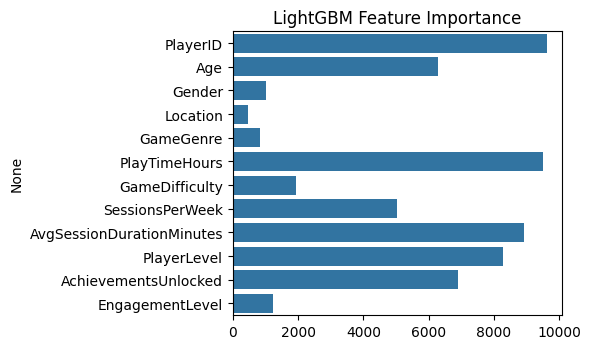

In [9]:
# -------------------------
# 7) 예측 & 평가
# -------------------------
# LightGBM은 확률로 예측함 (0~1)
proba = model.predict(X_test, num_iteration=model.best_iteration)

# 임계값 0.5 컷오프
pred = (proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

# -------------------------
# 8) Feature Importance
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, len(X.columns) * 0.3))
sns.barplot(
    x=model.feature_importance(),
    y=X.columns
)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()